![Py4Eng](img/logo.png)

# Convolutional Neural Networks with Keras
## Yoav Ram

In this session we will understand:
- how to use Keras as a high-level neural networks library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

from tensorflow import keras
print('Keras', keras.__version__)

Keras 2.1.6-tf


# Multilayer Convolutional Network

We build a multilayer convolutional neuron network.

This includes applying convolution filters on the images, pooling, and then applying softmax regression in the readout layer.
We also use dropout to reduce over-fitting.

For details on the operations see the [FFN session](FFN.ipynb) and the [CNN session](CNN.ipynb).

**Note** Training this model may take SOME TIME!!

# Keras

[Keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) (MS deep learning package), or [Theano](http://www.deeplearning.net/software/theano/).

The main benefit is that it *allows for easy and fast prototyping*.

We'll use the Keras that is installed with TensorFlow; for a more updated version we could install with `conda install -c conda-forge keras`.

## Get the data

We use Keras' datasets module to load the data:

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train/255
X_test = X_test/255

That last step of normalizing the data to be floats between 0 and 1 (it's originally betweeen 0 and 255 in integers) is crucial, although you could probably instead just change how the weights of the network are initialized.

Now let's do one-hot encoding of the labels:

In [3]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

The images are 1D arrays of length 28x28=784; the labels are one-hot encodes numbers between 0 and 9:

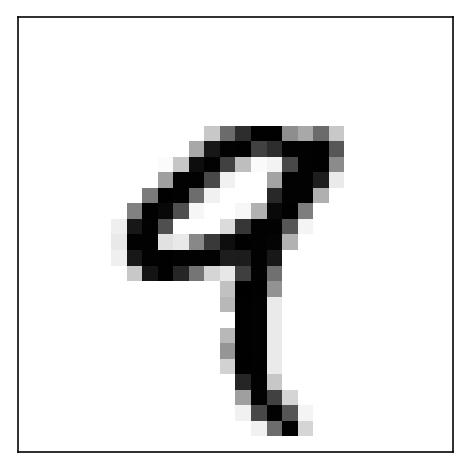

In [4]:
def display_image(im):
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
display_image(X_train[4])

## Keras model

We start by creating a Keras model, the neural network, to which we will add the different layers.
This model is a `Sequential` model, that is, data flows sequentially from one layer to the next.

The first layer has to reshape the data from width-by-height to width-by-height-by-channels, because 2D convolutions expect their input to be 3D (think color images, in which the channels are RGB).

Note that the first layer in any model must have the `input_shape` parameter that defines the shape of a single input sample. 
Other layers can infer their shape from the previous layers (sequential model!)

In [5]:
model = keras.models.Sequential()
model.add(
    keras.layers.Reshape((width, height, 1), input_shape=(width, height)))

## First convolutional layer

The first layer has a convolution followed by max pooling.

The convolution computes 32 features of 5x5 patches; given a 4D input tensor of shape `[batch=-1, in_height=28, in_width=28, in_channels=1]` and a 4D filter / kernel tensor of shape `[filter_height=5, filter_width=5, in_channels=1, out_channels=32]`, the convolution:

1. Flattens the filter to a 2-D matrix with shape
   `[filter_height * filter_width * in_channels = 5*5*1, out_channels=32]`.
2. Extracts image patches from the input tensor to form a *virtual*
   tensor of shape `[batch=-1, out_height=28, out_width=28, filter_height * filter_width * in_channels = 5*5*1]`.
3. For each patch, right-multiplies the filter matrix and the image patch
   vector.
   
So the convolution accepts `batches x 28 x 28 x 1` data shape and returns `batches x 28 x 28 x 32`.
   
We then add the bias vector and apply a ReLu activation function ($f(x)=max(0,x)$).

The pooling computes the max of every 2x2 patch, thus reducing the data shape to `batches x 14 x 14 x 32`.

In [6]:
model.add(
    keras.layers.Conv2D(32, (5, 5), activation='relu'))
model.add(
    keras.layers.MaxPool2D())

## Second convolutional layer

We add another convolution + pooling layer, the 2nd layer will have 64 features. The input has 32 channels (from the previous 32 features) but he data arrays are smaller (14x14) due to the previous pooling:

In [7]:
model.add(
    keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(
    keras.layers.MaxPool2D())

The data is now is shape `batchesx7x7x64`.

## Fully connected layer

Now we add a fully-connected layer with 1024 neurons. This is done by matrix multiplication with a 7x7x64-by-1024 weight matrix. 
But first we need to flatten the input from 7x7x64 to 3136.

In [8]:
model.add(
    keras.layers.Flatten())
model.add(
    keras.layers.Dense(1024, activation='relu'))

## Dropout layer

We apply a dropout to reduce overfitting: the dropout stochasticly removes neurons (outputs of the previous layer) and automatically scales the neurons it retained so that their expected sum remains unchanged. `dropout` accepts a `keep_prob` argument which defines the probability that a neuron is kept. We provide this probability as a `placeholder` to that dropout can be turned on (during training) and off (during testing / predicting).

In [9]:
model.add(
    keras.layers.Dropout(0.5))

## Readout layer

We add a Softmax regression layer, similar to the previous, simpler example, including the regression coefficients, bias, and the softmax function:

In [10]:
model.add(
    keras.layers.Dense(ncats, activation='softmax'))

Now let's visualize the model:

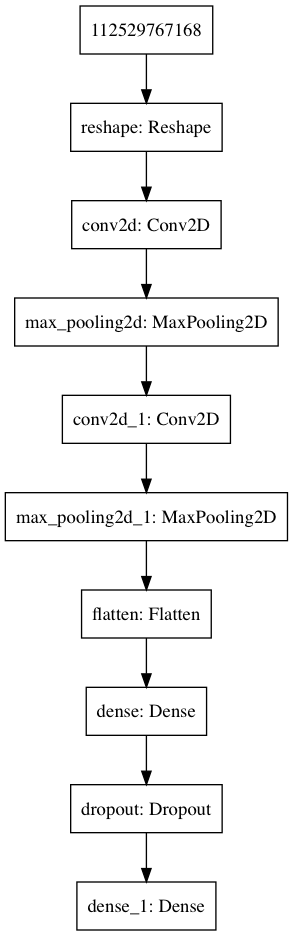

In [11]:
keras.utils.plot_model(model, to_file='tmp.png')
keras.preprocessing.image.load_img('tmp.png')

## Training

To train the model we need to define the loss function. We'll use the same cross entropy function as before. We also use the same measure for accuracy - we predict the most likelihood class and check that it is the correct label.

We use the [Adam optimizer](http://arxiv.org/pdf/1412.6980.pdf), an algorithm for stochastic gradient descent based on adaptive estimates of first and second moments.

In [12]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

The actual training takes about 15-20 mins on a MacBook Pro 13" 2016 with max specs, reaching accuracy >99% on the validation set.

In [14]:
history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=5, 
    validation_data=(X_test, Y_test),
).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s 1ms/step - loss: 0.1323 - acc: 0.9584 - val_loss: 0.0458 - val_acc: 0.9844
Epoch 2/5
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0450 - acc: 0.9861 - val_loss: 0.0325 - val_acc: 0.9893
Epoch 3/5
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0315 - acc: 0.9904 - val_loss: 0.0242 - val_acc: 0.9916
Epoch 4/5
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0246 - acc: 0.9923 - val_loss: 0.0246 - val_acc: 0.9914
Epoch 5/5
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0281 - val_acc: 0.9920


Interestingly, the neural network very quickly achieves a better accuracy than the previous approach - after one epoch the validation accuracy is > 0.98.
The validation accuracy then fluctuates for a long time around 0.99.

Save the model and the history:

In [15]:
model.save('../data/keras_cnn_model.h5')
with open("../data/keras_cnn_history.p", "wb") as f:
    pickle.dump(history, f)

Load model and history:

In [16]:
model = keras.models.load_model('../data/keras_cnn_model.h5')
with open("../data/keras_cnn_history.p", "rb") as f:
    history = pickle.load(f)

Plot history:

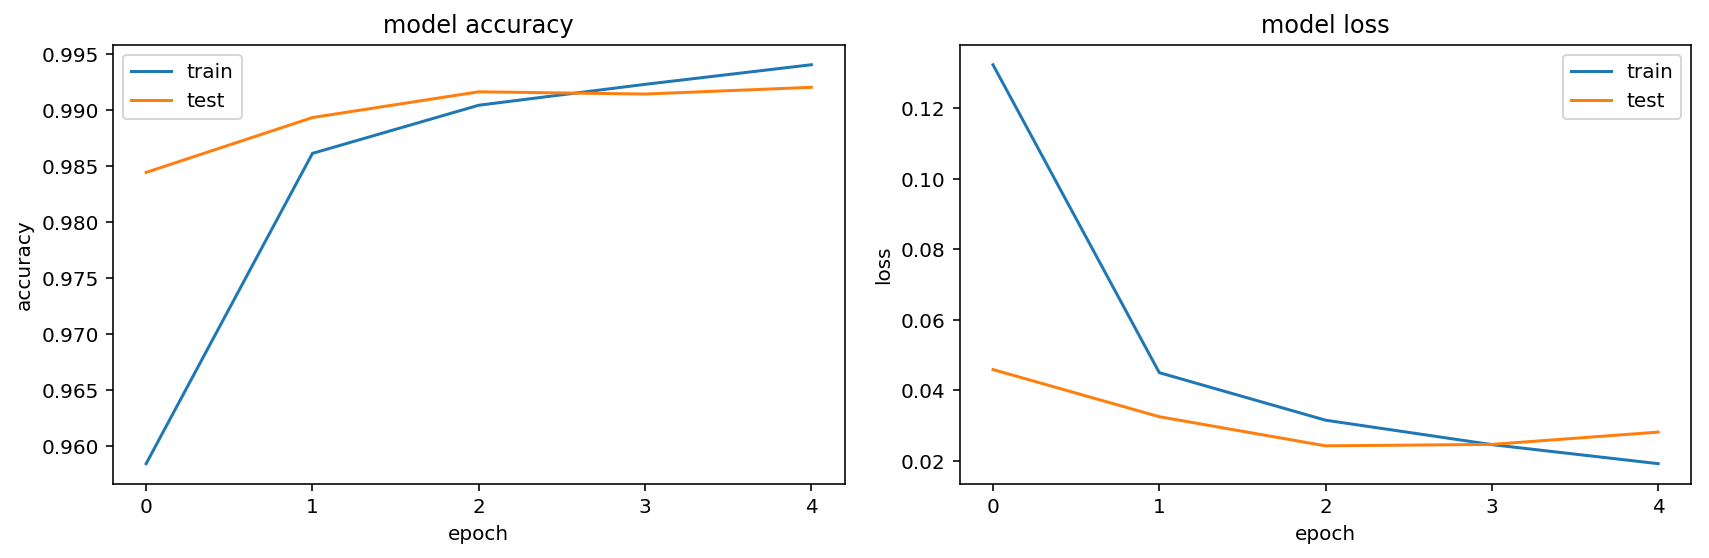

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

ax = axes[0]
ax.plot(history['acc'], label='train')
ax.plot(history['val_acc'], label='test')
ax.set(
    title='model accuracy',
    ylabel='accuracy',
    xlabel='epoch',
    xticks=np.arange(0, 5)
)
ax.legend()

ax = axes[1]
ax.plot(history['loss'], label='train')
ax.plot(history['val_loss'], label='test')
ax.set(
    title='model loss',
    ylabel='loss',
    xlabel='epoch',
    xticks=np.arange(0, 5)
)
ax.legend()
    
fig.tight_layout()

We can also visualize the network weights using [Quiver](https://keplr-io.github.io/quiver/).

# References

- Keras [examples](https://github.com/keras-team/keras/tree/master/examples)
- [Fashion-MNIST CNN exercise](../exercises/CNN.ipynb)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)